In [225]:
import matplotlib.pyplot as plt
import math
import numpy as np
from graphviz import Digraph
%matplotlib inline

In [160]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n._grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [529]:
# Definition of container for autodifferentiation and compute graph storage

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self._prev = set(_children)
        self.data = data
        self._op = _op
        self.label = label
        self._grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+", label=f"{self.label} + {other.label}")
        
        def _backward():
            self._grad += out._grad * 1.0
            other._grad += out._grad * 1.0
            
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = self + (-1 * other)
        
        return out
    
    def __rsub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = other + (-1 * self)
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op="*", label=f"{self.label} * {other.label}")

        def _backward():
            self._grad += out._grad * other.data
            other._grad += out._grad * self.data
            
        out._backward = _backward
            
        return out
    
    def tanh(self):
        x = self.data
        e_x = math.exp(2*x)
        t = (e_x - 1) / (e_x + 1)
        out = Value(t, _children=(self,), _op="tanh", label=f"tanh({self.label})")
        
        def _backward():
            self._grad += out._grad * (1 - t**2)
            
        out._backward = _backward
        
        return out
    
    def relu(self):
        x = self.data
        if x < 0:
            out = Value(0, _op="relu", _children=(self, ))
        else:
            out = Value(x, _op="relu", _children=(self, ))
        
        def _backward():
            if x > 0:
                self._grad += out._grad
            
        out._backward = _backward
        
        return out
    
    def prelu(self, p): # parametric relu
        x = self.data
        if x < 0:
            out = p * self
        else:
            out = Value(x, _op="prelu", _children=(self, p))
        
        def _backward():
            if x > 0:
                self._grad += out._grad
            else:
                self._grad += p.data * out._grad
                p._grad += self.data * out._grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        e_x = math.exp(self.data)
        out = Value(e_x, _op="exp", label=f"e^{self.label}", _children=(self,))
        
        def _backward():
            self._grad += out._grad * e_x
            
        out._backward = _backward
        
        return out
        
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self * other**-1
        
        return out
    
    def __rtruediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = other * self**-1
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data ** other.data, _children=(self, other), _op="pow", label=f"{self.label} ^ {other.label}")
        
        def _backward():
            self._grad += other.data * (self.data ** (other.data - 1)) * out._grad
            other._grad += out._grad
            
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_top(node):
            if node not in visited:
                visited.add(node)
                for c in node._prev:
                    build_top(c)
                topo.append(node)

        build_top(self) # build the sorted graph
        
        self._grad = 1
        
        for n in reversed(topo):
            n._backward()
        

In [162]:
# make sure that the end node is at the end of the list to call backprop on it first

def topsort(graph):
    topo = []
    visited = set()

    def build_top(node):
        if node not in visited:
            visited.add(node)
            for c in node._prev:
                build_top(c)
            topo.append(node)
        
    build_top(graph)
    
    return topo

In [171]:
x1 = Value(2.0, label="x1")
x2 = Value(0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1, label="w2")
b = Value(6.8813735, label="b")

x1w1 = x1 * w1
x2w2 = x2 * w2

summ = x1w1 + x2w2
neur = summ + b
act = neur.tanh()

print(act)

Value(data=0.7071067376767731)


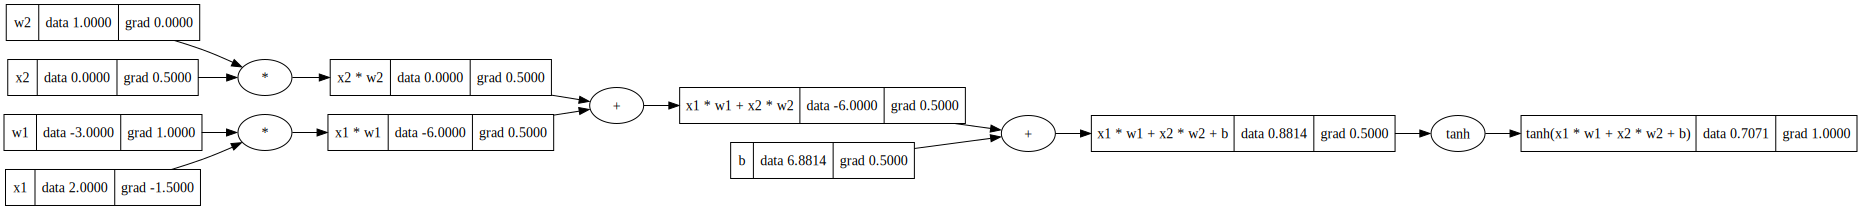

In [174]:
draw_dot(act)

In [173]:
act.backward()

In [221]:
x1 = Value(2.0, label="x1")
x2 = Value(0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1, label="w2")
b = Value(6.8813735, label="b")

x1w1 = x1 * w1
x2w2 = x2 * w2

summ = x1w1 + x2w2
neur = summ + b
act = ((2 * neur).exp() - 1) / ((2 * neur).exp() + 1)

print(act)

Value(data=0.7071067376767731)


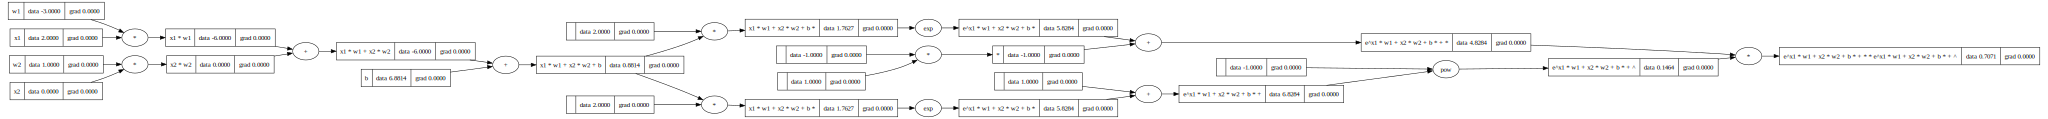

In [222]:
draw_dot(act)

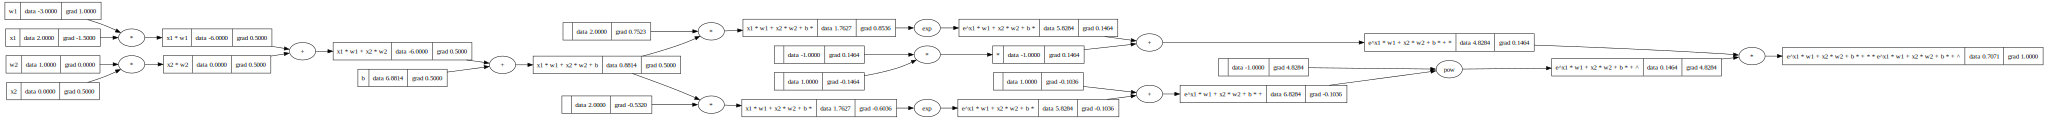

In [223]:
act.backward()
draw_dot(act)

In [645]:
# Definition of neural network stuff

class Neuron:
    def __init__(self, ndim=2, act=None):
        assert act in ["tanh", "relu", "prelu", None]
        
        self.w = [Value(v, label=f"w") for v in np.random.normal(loc=0, scale=math.sqrt(2 / ndim), size=ndim)] # He init
        self.b = Value(0, label="b") # init bias to 0
        self.act = act # save activation name
        
        if self.act == "prelu":
            self.p = Value(0.01)
        
    def forward(self, x):
        inner_prod = sum([x*w for x, w in zip (x, self.w)])
        out = inner_prod + self.b
        
        if self.act == "prelu":
            act = getattr(out, self.act)
            out = act(self.p)
        elif self.act is not None:
            act = getattr(out, self.act)
            out = act()
        
        return out
        
    def __call__(self, x):
        return self.forward(x)
    
class Layer:
    def __init__(self, nin=32, nout=32, act=None):
        assert act in ["tanh", "relu", "prelu", None]
        
        self.neurons = [Neuron(ndim=nin, act=act) for i in range(nout)] # create neurons
    
    def forward(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
    def __call__(self, x):
        return self.forward(x)
    
class MLP:
    def __init__(self, nin, dims, nout, act="tanh"):
        assert isinstance(dims, list)
        assert len(dims) > 0
        assert isinstance(nout, int)
        
        nlayers = len(dims)
        
        self.layers = [Layer(nin=nin, nout=dims[0], act=act)]
        self.layers.extend([Layer(nin=dims[i], nout=dims[i+1], act=act) for i in range(0, nlayers-1)])
        self.out = Layer(nin=dims[-1], nout=nout, act="tanh")
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
            
        out = self.out(x)[0]
        return out
        
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        params = []

        for l in self.layers:
            for n in l.neurons:
                params.extend(n.w)
                params.extend([n.b])
                
                if hasattr(n, "p"):
                    params.extend([n.p])
                
        return params
        

In [646]:
class SGD:
    def __init__(self, parameters=[], lr=0.01):
        self.parameters = parameters
        self.lr = lr
        
    def step(self):
        for p in self.parameters:
            p.data = p.data - self.lr * p._grad
            
    def zero_grad(self):
        for p in self.parameters:
            p._grad = 0

In [647]:
# Definition of the loss function

def mse(pred, gt):
    return (pred - gt)**2

In [666]:
mlp = MLP(nin=2, dims=[16, 16], nout=1, act="prelu")
opt = SGD(mlp.parameters(), lr=0.005)

In [659]:
# simple dataset: the target is the sign of the product

xs = np.random.uniform(low=-1, high=1, size=20)
ys = np.random.uniform(low=-1, high=1, size=20)

ds = [[x, y, np.sign(x * y)] for x, y in zip(xs, ys)]

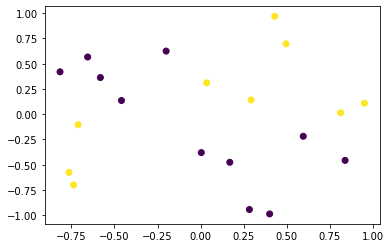

In [660]:
plt.figure()
plt.scatter(xs, ys, c=np.sign(xs * ys))
plt.show()

In [667]:
# train the mini network for 100 epochs

epochs = 100
losses = []

for i in range(epochs):
    running_loss = 0
    
    # use minibatch SGD
    for d in ds:
        opt.zero_grad()
        target = d[-1] # target
        ins = d[0:2] # inputs
        
        pred = mlp(ins) # get predictions
        
        loss = mse(pred, target)
        running_loss += loss
        loss.backward()
        opt.step()

    losses.append(running_loss.data / len(ds))    

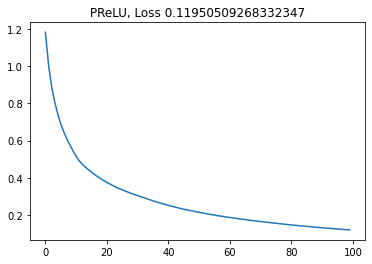

In [668]:
plt.plot(losses)
plt.title(f"PReLU, Loss {losses[-1]}")
plt.show()

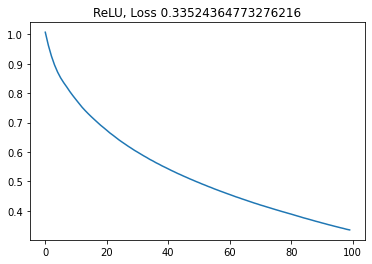

In [662]:
plt.plot(losses)
plt.title(f"ReLU, Loss {losses[-1]}")
plt.show()

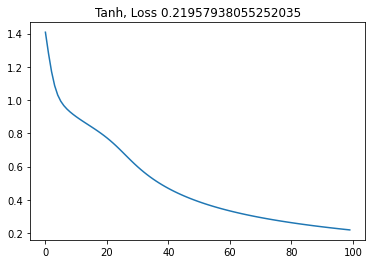

In [665]:
plt.plot(losses)
plt.title(f"Tanh, Loss {losses[-1]}")
plt.show()

In [656]:
mlp([-1, 1])

Value(data=-0.9350651959454773)

(-1.9878391582467352, 1.7621608417532648)

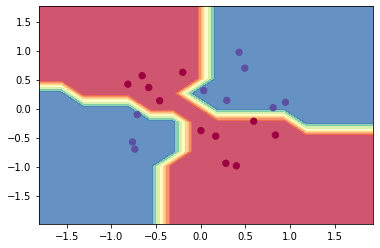

In [669]:
# visualize decision boundary

h = 0.25
x_min, x_max = xs.min() - 1, xs.max() + 1
y_min, y_max = ys.min() - 1, ys.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(mlp, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

xs = [d[0] for d in ds]
ys = [d[1] for d in ds]
lab = [d[-1] for d in ds]

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xs, ys, c=lab, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())